In [2]:
import os, sys
import bagpipes as pipes
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from _utils import IO_funcs as IO
-2
galaxy_name = 'test_new'

results_df = pd.read_csv('Galaxies/{0}/Results_Bagpipes/pipes/cats/{0}_final_results.csv'.format(galaxy_name))

from matplotlib import cm, rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from matplotlib import cm, gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
fits_base = IO.FitsUtils('Galaxies/{0}/f444w_POOLED.fits'.format(galaxy_name), 'f444w', 'sci')

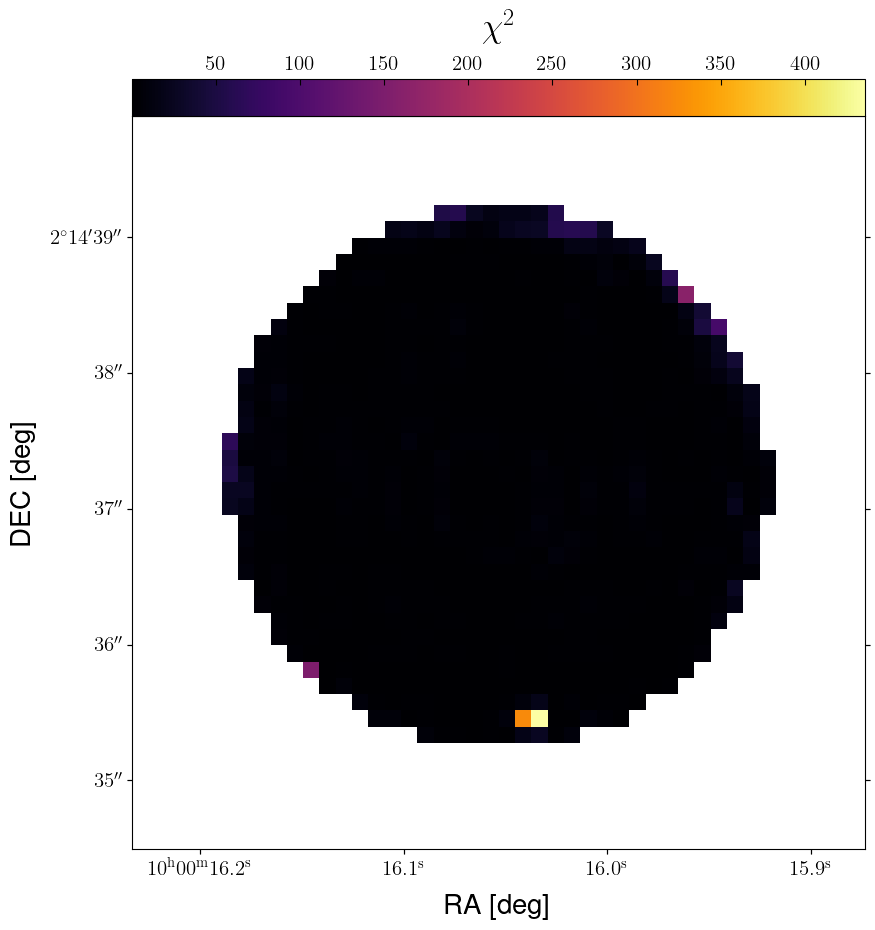

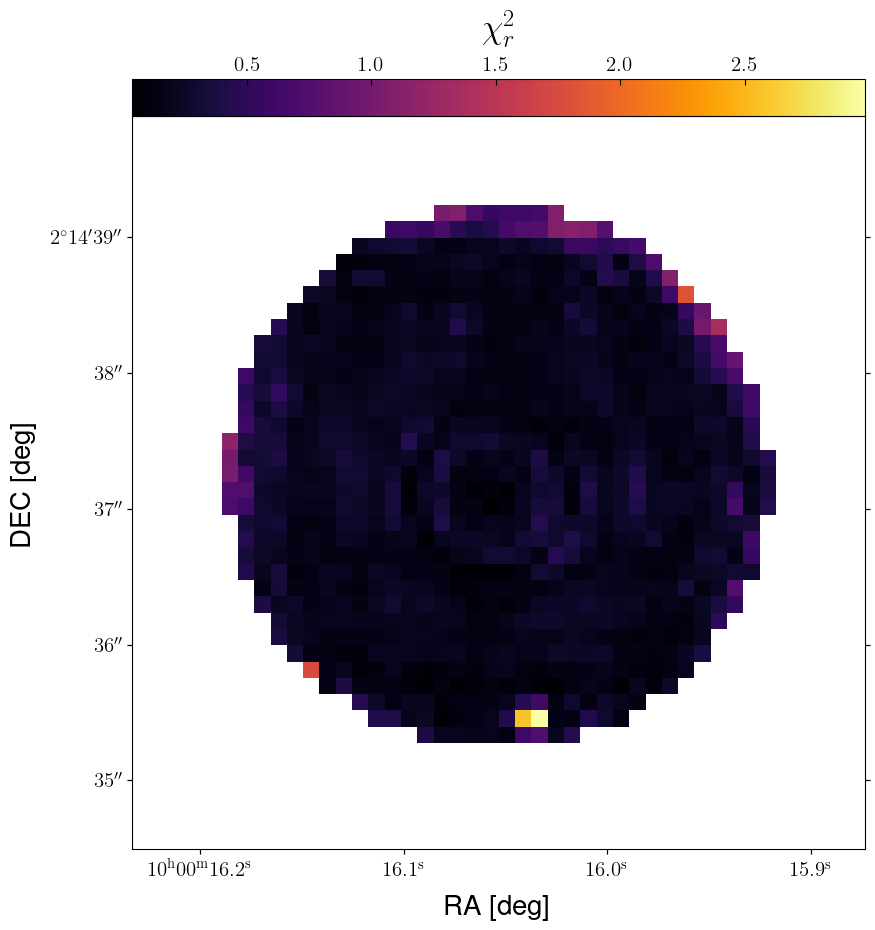

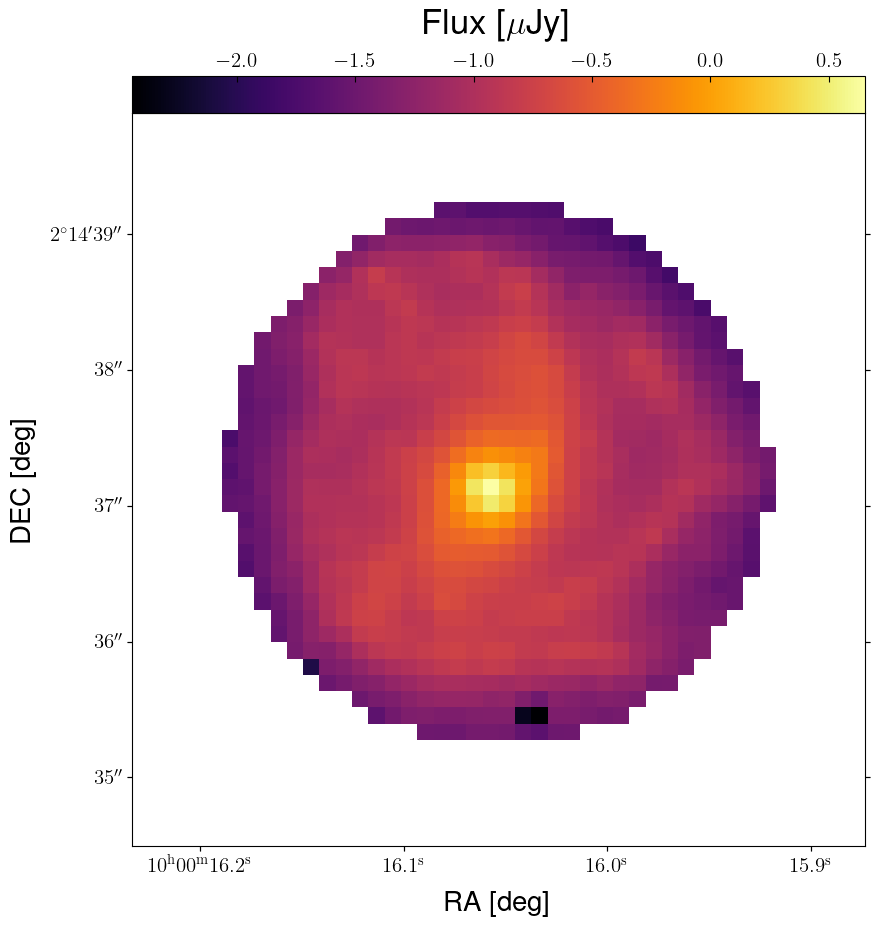

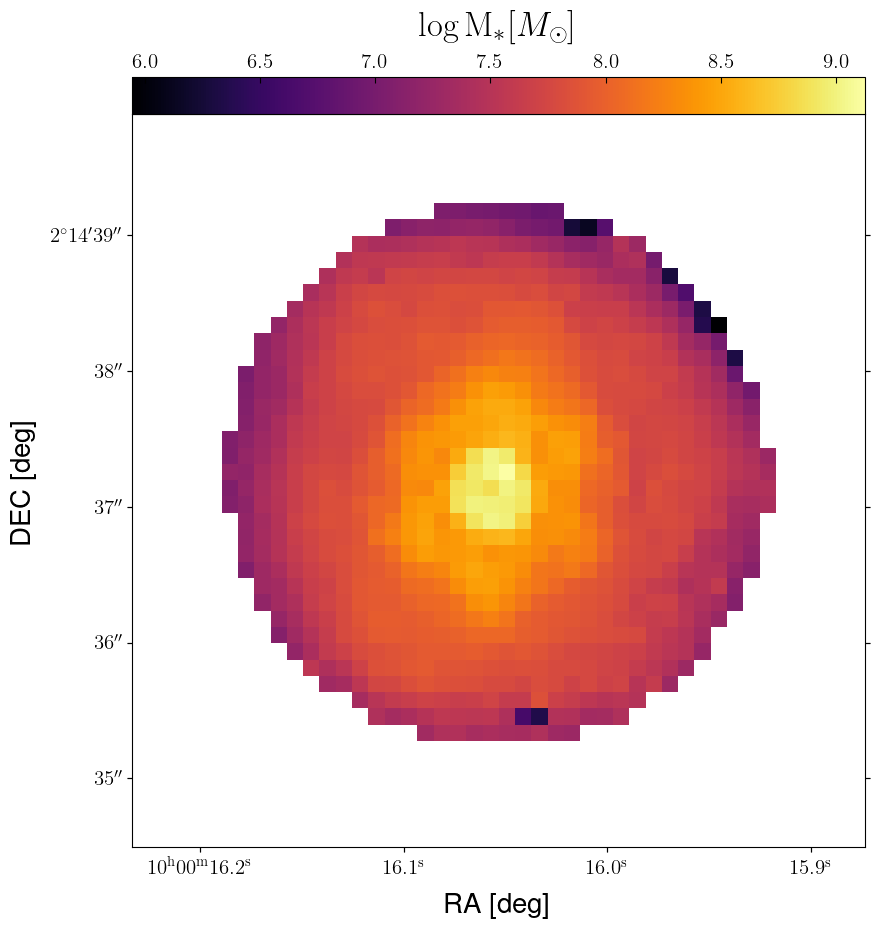

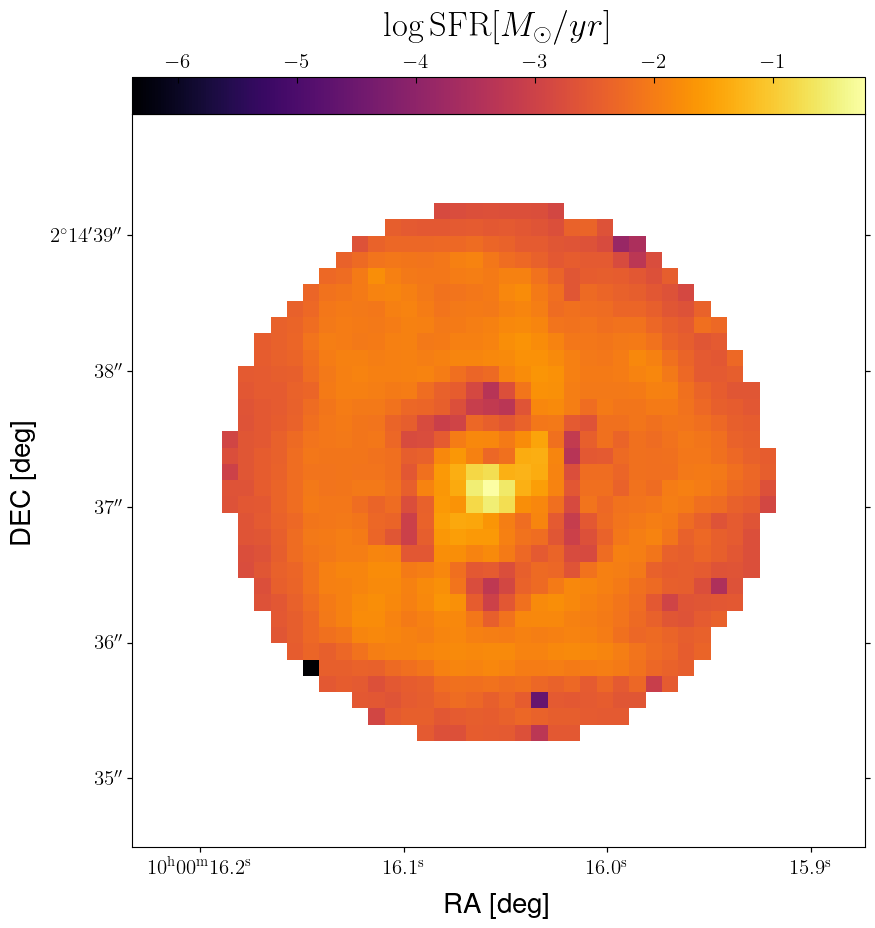

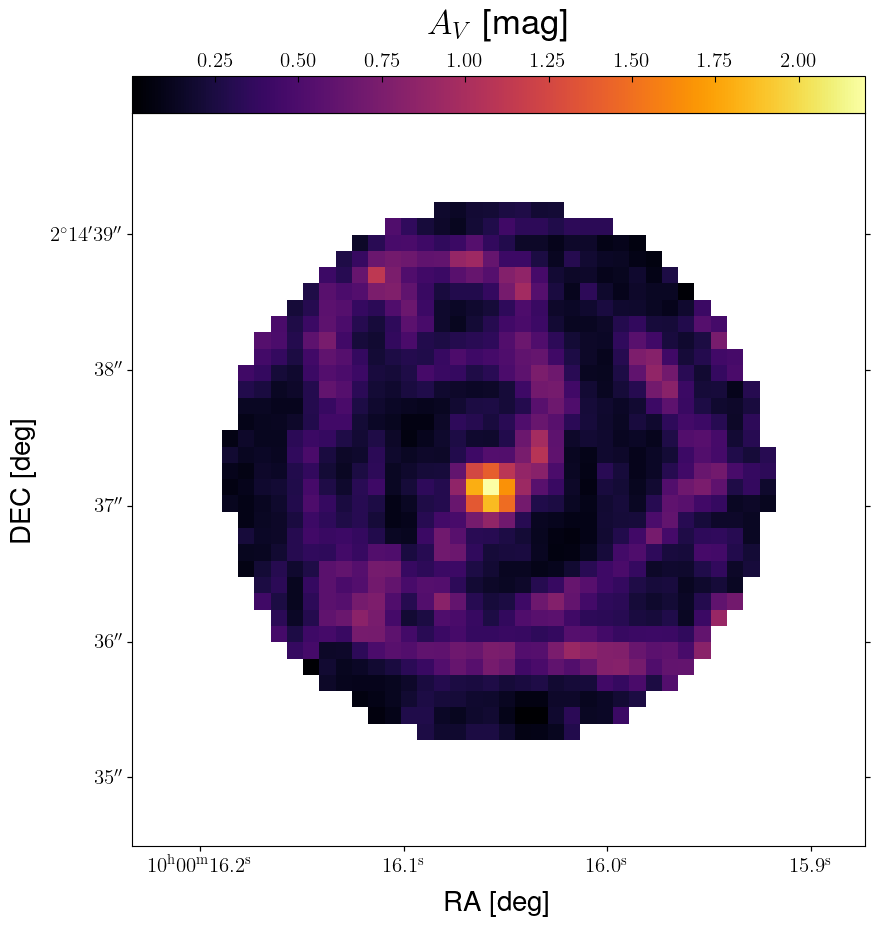

In [3]:
def plot_quantity(fits_base, quantity, label, savepath, xmin, xmax, ymin, ymax, \
                  chisq_mask = False, chisq_map = None, chisq_threshold = 30, \
                  cmap = cm.inferno):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111, projection = fits_base.wcs)
    ax.coords[0].set_axislabel('RA [deg]', size = 20), ax.coords[1].set_axislabel('DEC [deg]', size = 20)
    ax.coords[0].set_ticklabel(size=15), ax.coords[1].set_ticklabel(size=15)
    if chisq_mask:
        c_BAD, c_GOOD = np.where(chisq_map > chisq_threshold), np.where(chisq_map <= chisq_threshold)
        masked_quantity = np.copy(quantity)
        masked_quantity[c_BAD] = np.nan
        ax.imshow(quantity, origin = 'lower', interpolation = 'nearest', cmap = cm.Greys)
        im = ax.imshow(masked_quantity, origin = 'lower', interpolation = 'nearest', cmap = cmap)
    else: im = ax.imshow(quantity, origin = 'lower', interpolation = 'nearest', cmap = cmap)
    ax.axis('equal')
    if xmin != 0: ax.set_xlim(xmin, xmax), ax.set_ylim(ymin, ymax)
    else: pass
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="5%", axes_class=maxes.Axes, pad=0.0)
    cax.tick_params(direction='in') 
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.outline.set_edgecolor('black')
    cax.xaxis.set_ticks_position('top')
    cax.tick_params(axis='both', which='major', length = 4.0, labelsize=15)
    cax.set_title(label, fontsize = 25, pad = 30)
    fig.savefig(savepath, bbox_inches = 'tight')
    
def save_fits(fits_base, quantity, label, code, savepath):
    from datetime import datetime
    from astropy.io import fits
    newhdr = fits_base.hdr
    newhdr['BUNIT'] = label
    newhdr['CODE'] = code
    newhdr['WHO'] = 'A. Enia'
    newhdr['WHEN'] = datetime.now().strftime("%d%b%Y %H:%M:%S")
    hdu = fits.PrimaryHDU(data = quantity, header = newhdr)
    hdu.writeto(savepath, overwrite=True)
    return

# Questo (plot + fits) DEVE diventare un unico loop
nx, ny = fits_base.hdr['NAXIS1'], fits_base.hdr['NAXIS2']
xmin, xmax = 40, 85 # CHISTU HAV'I A CANCIARI QUANNU
ymin, ymax = 40, 85 # HAVI A FARI 'U CATALOGO FINALE
chisq_threshold = 100

chisqmap = np.zeros((nx, ny))
chisqmap[chisqmap == 0] = np.nan
chisqmap[results_df.PIX_Y.values, results_df.PIX_X.values] = results_df.chisq_phot.values
plot_quantity(fits_base, chisqmap, r'$\chi^2$', 'pipes/{}_chisq.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax)

red_chisqmap = np.zeros((nx, ny))
red_chisqmap[red_chisqmap == 0] = np.nan
red_chisqmap[results_df.PIX_Y.values, results_df.PIX_X.values] = np.sqrt(results_df.chisq_phot.values)/7
plot_quantity(fits_base, red_chisqmap, r'$\chi^2_r$', 'pipes/{}_redchisq.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax)

f444w = np.zeros((nx, ny))
f444w[f444w == 0] = np.nan
f444w[results_df.PIX_Y.values, results_df.PIX_X.values] = np.log10(results_df.f444w.values)
plot_quantity(fits_base, f444w, r'Flux [$\mu$Jy]', 'pipes/{}_f444w_chisq.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax, \
              chisq_mask = True, chisq_map = red_chisqmap, chisq_threshold = chisq_threshold)

#zmap = np.zeros((nx, ny))
#zmap[zmap == 0] = np.nan
#zmap[results_df.PIX_Y.values, results_df.PIX_X.values] = results_df.redshift_50.values
#plot_quantity(fits_base, zmap, r'$z_{\rm phot}$', 'pipes/{}_photoz.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax, \
#              chisq_mask = True, chisq_map = red_chisqmap, chisq_threshold = chisq_threshold)

massmap = np.zeros((nx, ny))
massmap[massmap == 0] = np.nan
massmap[results_df.PIX_Y.values, results_df.PIX_X.values] = results_df.formed_mass_50.values
plot_quantity(fits_base, massmap, r'$\log {\rm M}_* [M_{\odot}]$', 'pipes/{}_mass.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax, \
              chisq_mask = True, chisq_map = red_chisqmap, chisq_threshold = chisq_threshold)

sfrmap = np.zeros((nx, ny))
sfrmap[sfrmap == 0] = np.nan
sfrmap[results_df.PIX_Y.values, results_df.PIX_X.values] = np.log10(results_df.sfr_50.values)
plot_quantity(fits_base, sfrmap, r'$\log {\rm SFR} [M_{\odot}/yr]$', 'pipes/{}_sfr.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax, \
              chisq_mask = True, chisq_map = red_chisqmap, chisq_threshold = chisq_threshold)

avmap = np.zeros((nx, ny))
avmap[avmap == 0] = np.nan
avmap[results_df.PIX_Y.values, results_df.PIX_X.values] = results_df['dust:Av_50'].values
plot_quantity(fits_base, avmap, r'$A_V$ [mag]', 'pipes/{}_Av.pdf'.format(galaxy_name), xmin, xmax, ymin, ymax, \
              chisq_mask = True, chisq_map = red_chisqmap, chisq_threshold = chisq_threshold)

save_fits(fits_base, chisqmap, 'chi2', 'BAGPIPES', 'pipes/{}_chi2.fits'.format(galaxy_name))
#save_fits(fits_base, zmap, 'photo-z', 'BAGPIPES', 'pipes/{}_photoz.fits'.format(galaxy_name))
save_fits(fits_base, massmap, 'logMstar', 'BAGPIPES', 'pipes/{}_mass.fits'.format(galaxy_name))
save_fits(fits_base, sfrmap, 'logSFR', 'BAGPIPES', 'pipes/{}_sfr.fits'.format(galaxy_name))
save_fits(fits_base, avmap, 'Av', 'BAGPIPES', 'pipes/{}_Av.fits'.format(galaxy_name))

---

In [ ]:
results_df.sfr_50.values.sum()